In [1]:
import os
import gc
import copy

import numpy as np
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

if os.path.basename(os.getcwd()) != 'PConv2Layer':
    os.chdir('..')

from utils.util import MaskGenerator
from utils.pconv_model import PConvUnet

BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [5]:
model = PConvUnet()
model.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)

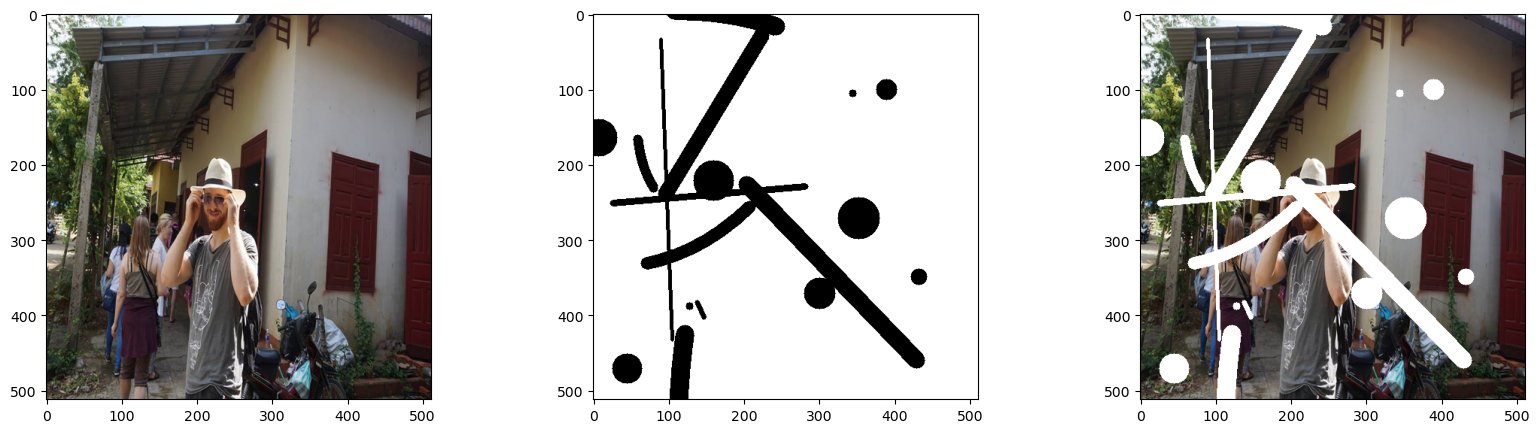

In [23]:
# testing the image
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

img = np.array(Image.open('./data/sample_image.jpg').resize((512, 512))) / 255

mask = mask_generator.sample()

masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)

In [24]:
# displaying the results
def plot_sample_data(masked, mask, pri, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

In [25]:
# creating the data generator
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            ori = next(super().flow(x, *args, **kwargs))
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1
            gc.collect()
            yield [masked, mask], ori

In [26]:
datagen = DataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)